# [過学習と学習不足について知る](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)

- 過学習（overfitting）
- 学習不足（underfitting）

解決策：
- より多くの訓練用データを使う
- モデルに保存される情報の量とタイプに制約を課す（正則化）

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.4.1


In [2]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

ヒッグス粒子に関するデータセットを利用する。11,000,000個の例があり、それぞれ28個の特徴量とバイナリーのラベルを持つ。

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [6]:
FEATURES = 28

`tf.data.experimental.CsvDataset`クラスはgzipファイルから解凍することなく直接csvレコードを読み取ることができる。

In [7]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

この操作により、それぞれのレコードについてスカラーのリストを得ることができる。次の操作により、ことリストを`(feature_vector, label)`のペアに変換（repack）する。

TensorFlowはデータのバッチを処理するのに適しているので、それぞれの行を変換するのではなく、10000個の例を含むバッチを受け取る新しい`Dataset`を作り、`pack_row`関数をそれぞれのバッチに適用、そしてバッチをレコードに戻していく。

In [8]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

In [9]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


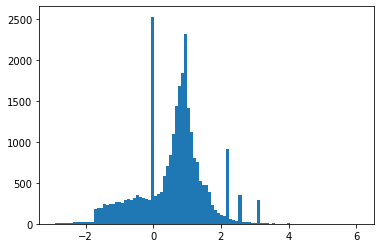

In [10]:
for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

ここでは、1000サンプルを検証用に、次の10000サンプルを学習用に利用する。

In [11]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

`Dataset.cache`メソッドによって、各エポックでファイルを再読み取りする必要がないようにする。

In [12]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

バッチを作成する。学習用データはバッチを作成する前に、`.shuffle`と`.repeat`をしておく。

In [13]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

もっとも簡単な過学習回避方法はモデルを小さくすること。

- 大きいモデル：記憶能力が高く簡単に学習することができるが、新しいデータに対する耐性が弱い
- 小さいモデル：汎用化し易いが、そもそも学習できないことがある

ちょうど良いモデルのサイズを決めることは難しく、実験によってベストな構造を探すしかない。より良いモデルサイズを見つけるには、少ない層とパラメータから始めて、層の数を増やすか、新しい層を挿入することで損失を小さくしていく方法が効果的である。

次の例では、`layers.Dense`層のみを持つ簡単なモデルから始める。

多くのモデルは学習率（learning rate）を徐々に小さくするとうまく学習できる。`optimizers.schedules`を使う。

In [14]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH * 1000,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

これにより、`schedule.InverseTimeDecay`は双曲線的に学習率を下げていく（1000エポックで始めの1/2、2000エポックで始めの1/3、、、）

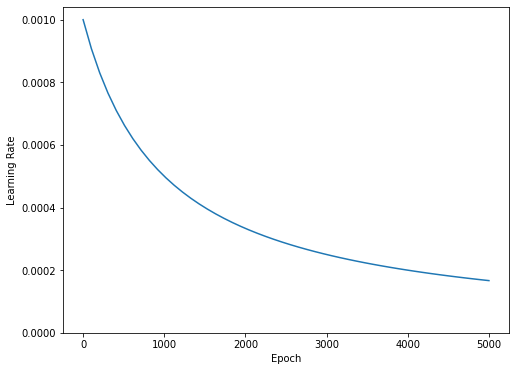

In [15]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

この実験では、多くの短いエポックで学習を行う。ノイズを避けるために、`tfdocs.EpochDots`を使って、全ての評価を100エポックずつ実行する。

次に、`callbacks.EarlyStopping`を使って長く不必要なステップを避ける。このコールバックでは`val_loss`ではなく`val_binary_crossentropy`を観察する（この違いは結構大事）。

学習のログを`callbacks.TensorBoard`で出力する。

```
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)
```
`monitor`に設定された評価値を観察して学習を停止する。変化量が`min_delta`以下のステップが`patience`回続いたら止める。

In [16]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir / name),
    ]

In [17]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
        
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
            'accuracy'
        ]
    )
    
    model.summary()
    
    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0
    )
    
    return history

小さいモデルから始める。

ELU (Exponential Linear Unit):
$$
    f(x) =
        \begin{cases}
            \alpha (e^x - 1), \quad x \leq 0 \\
            x, \quad x > 0 \\
        \end{cases} (\alpha > 0)
$$

In [18]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [19]:
size_histories = {}

In [20]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4916,  binary_crossentropy:0.8806,  loss:0.8806,  val_accuracy:0.4800,  val_binary_crossentropy:0.8507,  val_loss:0.8507,  
....................................................................................................
Epoch: 100, accuracy:0.5985,  binary_crossentropy:0.6274,  loss:0.6274,  val_accuracy:0.5820,  val_binary_crossentropy:0.6276,  val_loss:0.6276,  
....................................................................................................
Epoch: 200, accuracy:0.62

パフォーマンスのチェック

(0.5, 0.7)

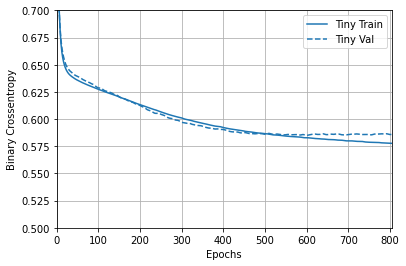

In [21]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

やや小さいモデルの学習を行う（隠れ層：2、各ユニット数：16）。

In [29]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [23]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5032,  binary_crossentropy:0.7520,  loss:0.7520,  val_accuracy:0.4780,  val_binary_crossentropy:0.7278,  val_loss:0.7278,  
....................................................................................................
Epoch: 100, accuracy:0.6192,  binary_crossentropy:0.6118,  loss:0.6118,  val_accuracy:0.6270,  val_binary_crossentropy:0.6070,  val_loss:0.

中ぐらいのモデルの学習（隠れ層：3、各ユニット数：64）

In [30]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [25]:
size_histories['Medium'] = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4913,  binary_crossentropy:0.6920,  loss:0.6920,  val_accuracy:0.4740,  val_binary_crossentropy:0.6798,  val_loss:0.6798,  
....................................................................................................
E

さらに大きいモデルで学習する。問題で必要とされる容量よりも多くの隠れ層を使って、過学習がどの程度早く始まるか見る。

In [31]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [32]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5155,  binary_crossentropy:0.8306,  loss:0.8306,  val_accuracy:0.4850,  val_binary_crossentr

学習で得られた交差エントロピーを図示する。

ポイント：

- 小さい違いがあるのが普通
- 同じ方向に落ちている間は、うまく学習ができている
- 検証による損失の変化が見られなくなったら、過学習が始まっているかもしれない
- 検証による損失が上昇し始めたら、過学習が始まっている

Text(0.5, 0, 'Epochs [Log Scale]')

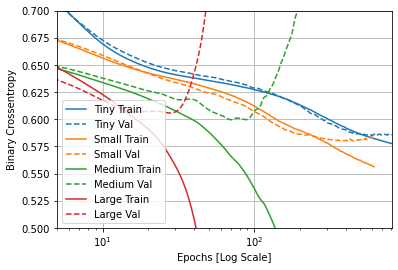

In [33]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

これらはTensorBoardログにすべて書き込まれる。

notebookでTensorBoardビューアーを開いてみる

In [34]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

前回の学習結果はTensorBoard.devを使って表示できる。`<iframe>`にも含まれている。

In [35]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

以下のコマンドをcode-cellに打つと、TensorBoardの結果をTensorBoard.devにアップロードできる（Googleアカウントが必要）。

In [38]:
tensorboard dev upload --logdir {logdir}/sizes

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/var/folders/25/bt3n4kt13qz0zrcj1x1l5jv40000gn/T/tmpko_jd665/tensorboard_logs/sizes

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Traceback (most recent call last):
  File "/Users/nakayamayasuaki/python_env/dl_env/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/Users/nakayamayasuaki/python_env/dl_env/lib/python3.8/site-packages/tensorboard/main.py", line 75, in run_main
  

過学習を避けるストラテジーの前に、比較のために`"Tiny"`モデルのログをコピーしておく。

In [39]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/var/folders/25/bt3n4kt13qz0zrcj1x1l5jv40000gn/T/tmpko_jd665/tensorboard_logs/regularizers/Tiny')

In [40]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

## 重み規制を追加する

重みに規制を追加する。大きさが大きい重みに関して、ネットワークの損失関数にコストを加算する。二つの規制手法がある。

- [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization)：追加されるコストは重みの絶対値に比例する（"L1 norm"と呼ばれる）。モデルはスパースモデルに近づく。
- [L2 regularization (weight decay)](https://developers.google.com/machine-learning/glossary/#L2_regularization)：追加されるコストは重みの二乗に比例する（"L2 norm"と呼ばれる）。スパースにならないように重みに規制を与える。

ここではL2 regularizationを`tf.keras`の層に追加する。

In [41]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_27 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_28 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5074,  binary_crossentropy:0.7663,  loss:2.2693,  val_accuracy:0.4800,  val_binary_crossentr

`l2(0.001)`：重み行列の各係数に関して、損失関数に`0.001 * weight_coefficientvalue**2`を加算する

`binary_crossentropy`を直接観察しているのは、このメトリックはL2の規制を含めて計算しないから

学習結果から過学習が起きにくいことがわかる

(0.5, 0.7)

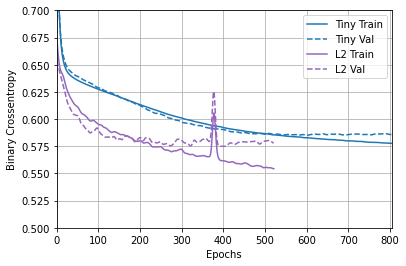

In [42]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

`"L2"`規制モデルはより新しいデータに対して強くなり、`"Tiny"`モデルとも比較できるレベルになった。

このタイプの規制モデルを使う時は以下の２点に気をつける

- 自分でループを書いている場合、損失に重みのコストを加算していることを意識する
- この実装では重みのコストを追加して、通常の最適化手法を用いている

もう一つの手法は、損失をそのまま最適化に渡すだけでなく、最適化中にも重みのペナルティを適応する。この"Decoupled Weight Decay"を利用する時は、`optimizers.FTRL`や`optimizers.AdamW`を使う。

In [43]:
result = l2_model(features)
regularization_loss = tf.add_n(l2_model.losses)

## ドロップアウトを追加する

トロント大学のHintonと彼の学生が考えた、ドロップアウト手法を使う。この手法は最も効果的で一般的である。

この手法の考えた方は、それぞれのノードは他のノードの出力に依存することはできないので、その値自体が便利である特徴量はそのまま出力しなければならない、である。この手法では、学習中にランダムにいくつかの特徴量を削除し、その特徴量を0にする。ドロップアウトさせる確率は0.2から0.5の間に設定するのが一般的。テスト評価の時には、このドロップアウトは行わず、代わりにドロップアウト確率と同じ割合だけ特徴量をスケールダウンさせる。

次のモデルでは`tf.layers.Dropout`層を追加する。

In [44]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)              

(0.5, 0.7)

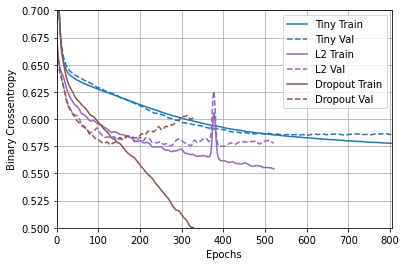

In [45]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

このモデルも`"Large"`モデルよりは良いが、`"Tiny"`モデルには及ばない。

次はL2規制とドロップアウトを一緒に使ってみる。

In [46]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)              

(0.5, 0.7)

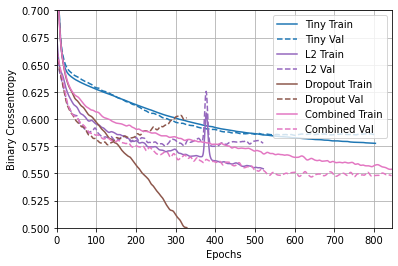

In [47]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [48]:
%tensorboard --logdir {logdir}/regularizers

In [49]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")

まとめ

過学習を避ける方法：

- より多くの学習データを使う
- ネットワークのキャパシティを減らす
- 重み規制を追加する
- ドロップアウトを追加する

これ以外にも方法はある：

- data-augmentation
- batch normalization

普通はいろいろな手法を一緒に使うことでより効率よく学習できる。